# TFL detection

### imports

In [1]:
import numpy as np, matplotlib.pyplot as plt
from os.path import join
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation,MaxPooling2D,BatchNormalization,Activation, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

### load and validate data

<class 'numpy.memmap'>
<class 'numpy.memmap'>
val :  (3912, 81, 81, 3) 0/1 split 50.0 %
train :  (24672, 81, 81, 3) 0/1 split 50.0 %


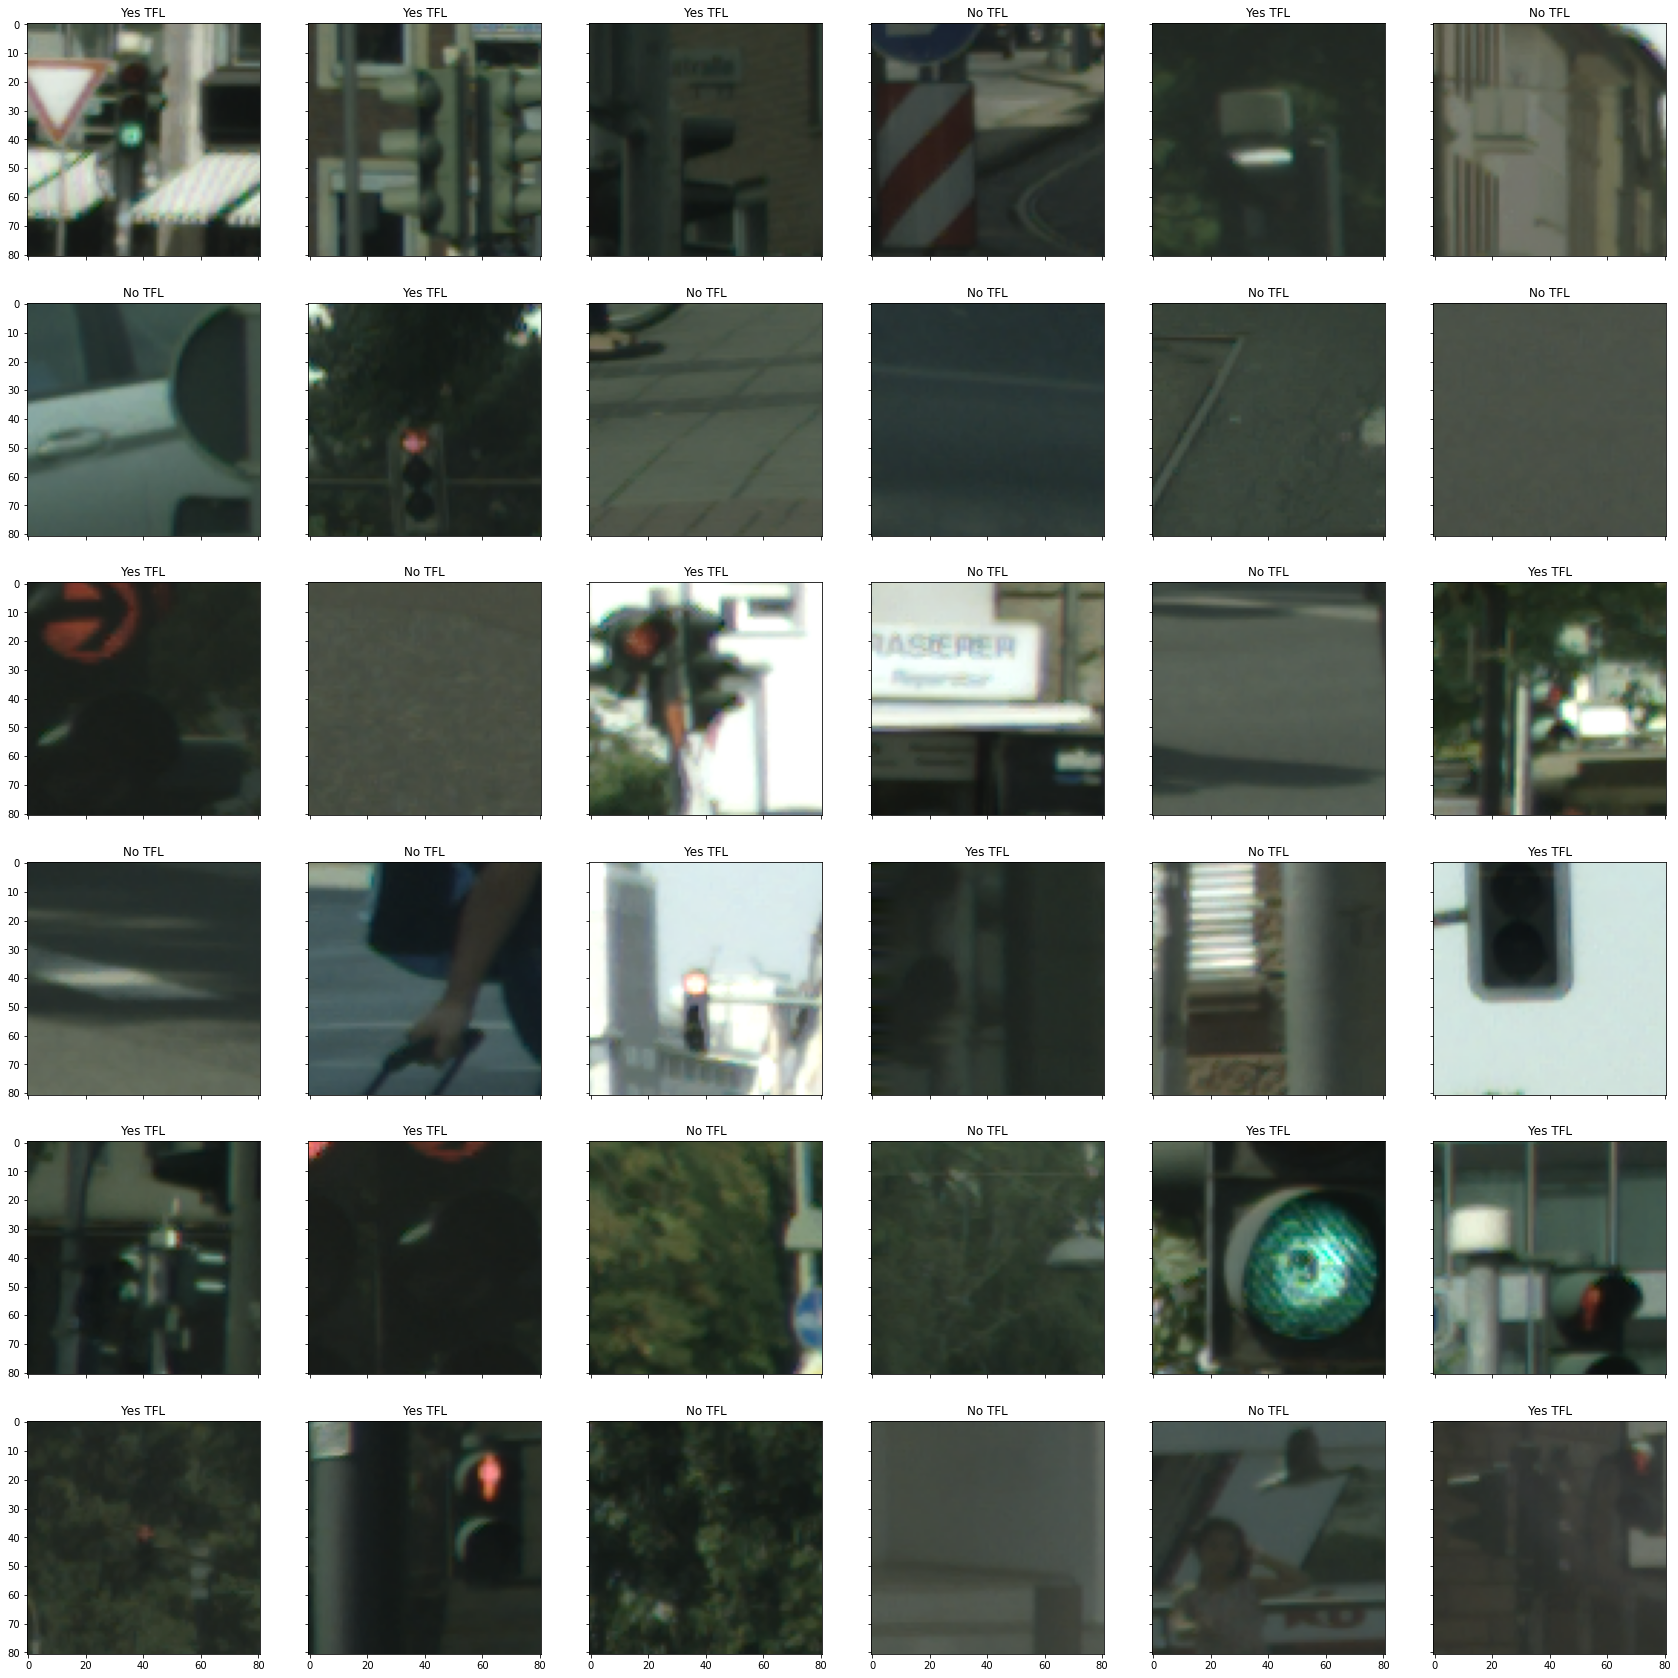

In [2]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    print(type(images))
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}

def viz_my_data(images,labels, predictions=None, num=(5,5), labels2name= {0:'No TFL',1:'Yes TFL'}):
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h = 5
    n = num[0]*num[1]
    ax = plt.subplots(num[0],num[1],figsize=(h*num[0],h*num[1]),gridspec_kw={'wspace':0.05},squeeze=False,sharex=True,sharey=True)[1]#.flatten()
    idxs = np.random.randint(0,images.shape[0],n)
    for i,idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None : title += ' Prediction: {:.2f}'.format(predictions[idx])
        ax.flatten()[i].set_title(title)
   

# root = './'  #this is the root for your val and train datasets
data_dir = 'data_dir'
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }
for k,v in datasets.items():
    
    print ('{} :  {} 0/1 split {:.1f} %'.format(k,v['images'].shape, np.mean(v['labels']==1)*100))

viz_my_data(num=(6,6),**datasets['val'])   

### define the model used for training

In [3]:
def tfl_model():
   my_input_shape =(81,81,3)
   
   model = Sequential()
   
   def conv_bn_relu(filters,**conv_kw):
       model.add(Conv2D(filters, use_bias=4, kernel_initializer='he_normal', padding='same', **conv_kw))
       model.add(BatchNormalization())
       model.add(Activation('relu'))
       
   def dense_bn_relu(units, bias):
       model.add(Dense(units, use_bias=bias, kernel_initializer='he_normal'))
       model.add(BatchNormalization())
       model.add(Activation('relu'))
   
   def spatial_layer(count, filters):
       for i in range(count):
           conv_bn_relu(filters, kernel_size=(5,5))
       conv_bn_relu(filters, kernel_size=(3,3), strides=(2,2))
   
   conv_bn_relu(32, kernel_size=(3,3), input_shape=my_input_shape)
   spatial_layer(1,12)
   spatial_layer(3,10)
   spatial_layer(2,8)
   spatial_layer(4,4)
   spatial_layer(2,4)
   
   
   model.add(Flatten())
   dense_bn_relu(96, 4)
   dense_bn_relu(36, 6)
   model.add(Dense(2, activation='softmax'))
   
   return model

m = tfl_model()
m.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 81, 81, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 81, 81, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 81, 81, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 81, 81, 12)        9612      
_________________________________________________________________
batch_normalization_1 (Batch (None, 81, 81, 12)        48        
_________________________________________________________________
activation_1 (Activation)    (None, 81, 81, 12)        0         
_________________________________________

### train

In [4]:
#prepare our model
m = tfl_model()
m.compile(optimizer=Adam(),loss =sparse_categorical_crossentropy,metrics=['accuracy'])

#train it, the model uses the 'train' dataset for learning. We evaluate the "goodness" of the model, by predicting the label of the images in the val dataset.
train,val = datasets['train'],datasets['val']
history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs =20)

Train on 24672 samples, validate on 3912 samples
Epoch 1/20
24672/24672 [==============================] - 1664s 67ms/sample - loss: 0.5409 - acc: 0.7146 - val_loss: 0.5915 - val_acc: 0.7365
Epoch 2/20
24672/24672 [==============================] - 1620s 66ms/sample - loss: 0.4056 - acc: 0.8126 - val_loss: 0.3947 - val_acc: 0.8175
Epoch 3/20
24672/24672 [==============================] - 1355s 55ms/sample - loss: 0.3662 - acc: 0.8361 - val_loss: 0.4050 - val_acc: 0.8198
Epoch 4/20
24672/24672 [==============================] - 1388s 56ms/sample - loss: 0.3449 - acc: 0.8459 - val_loss: 0.3870 - val_acc: 0.8308
Epoch 5/20
24672/24672 [==============================] - 1370s 56ms/sample - loss: 0.3273 - acc: 0.8529 - val_loss: 0.4190 - val_acc: 0.8014
Epoch 6/20
24672/24672 [==============================] - 1388s 56ms/sample - loss: 0.3212 - acc: 0.8593 - val_loss: 0.4005 - val_acc: 0.8039
Epoch 7/20
24672/24672 [==============================] - 1204s 49ms/sample - loss: 0.3093 - acc: 0

### compare train vs val acccuracy

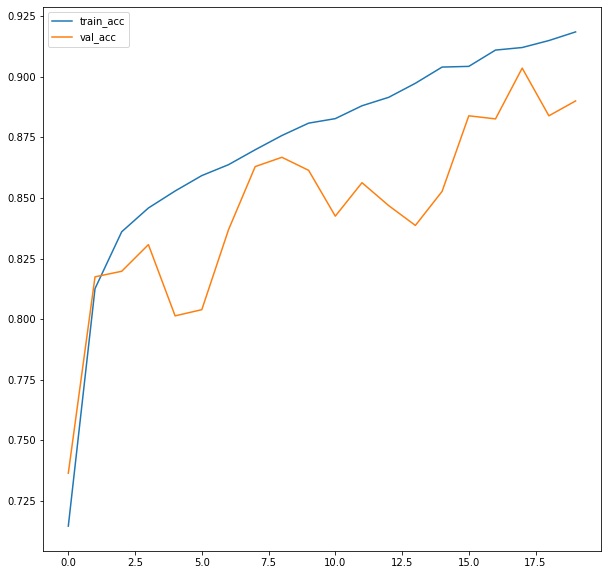

In [5]:
#compare train vs val acccuracy, 
# why is val_accuracy not as good as train accuracy? are we overfitting?
epochs = history.history
epochs['train_acc'] = epochs['acc']
plt.figure(figsize=(10,10))
for k in ['train_acc','val_acc']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)

plt.legend();

### evaluate and predict

accuracy: 0.8900817995910021


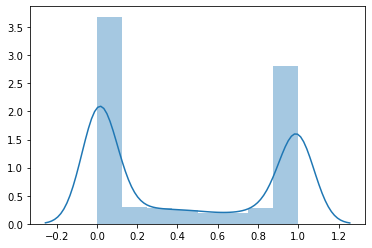

In [7]:
import seaborn as sbn
predictions = m.predict(val['images'])
sbn.distplot(predictions[:,0]);

predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

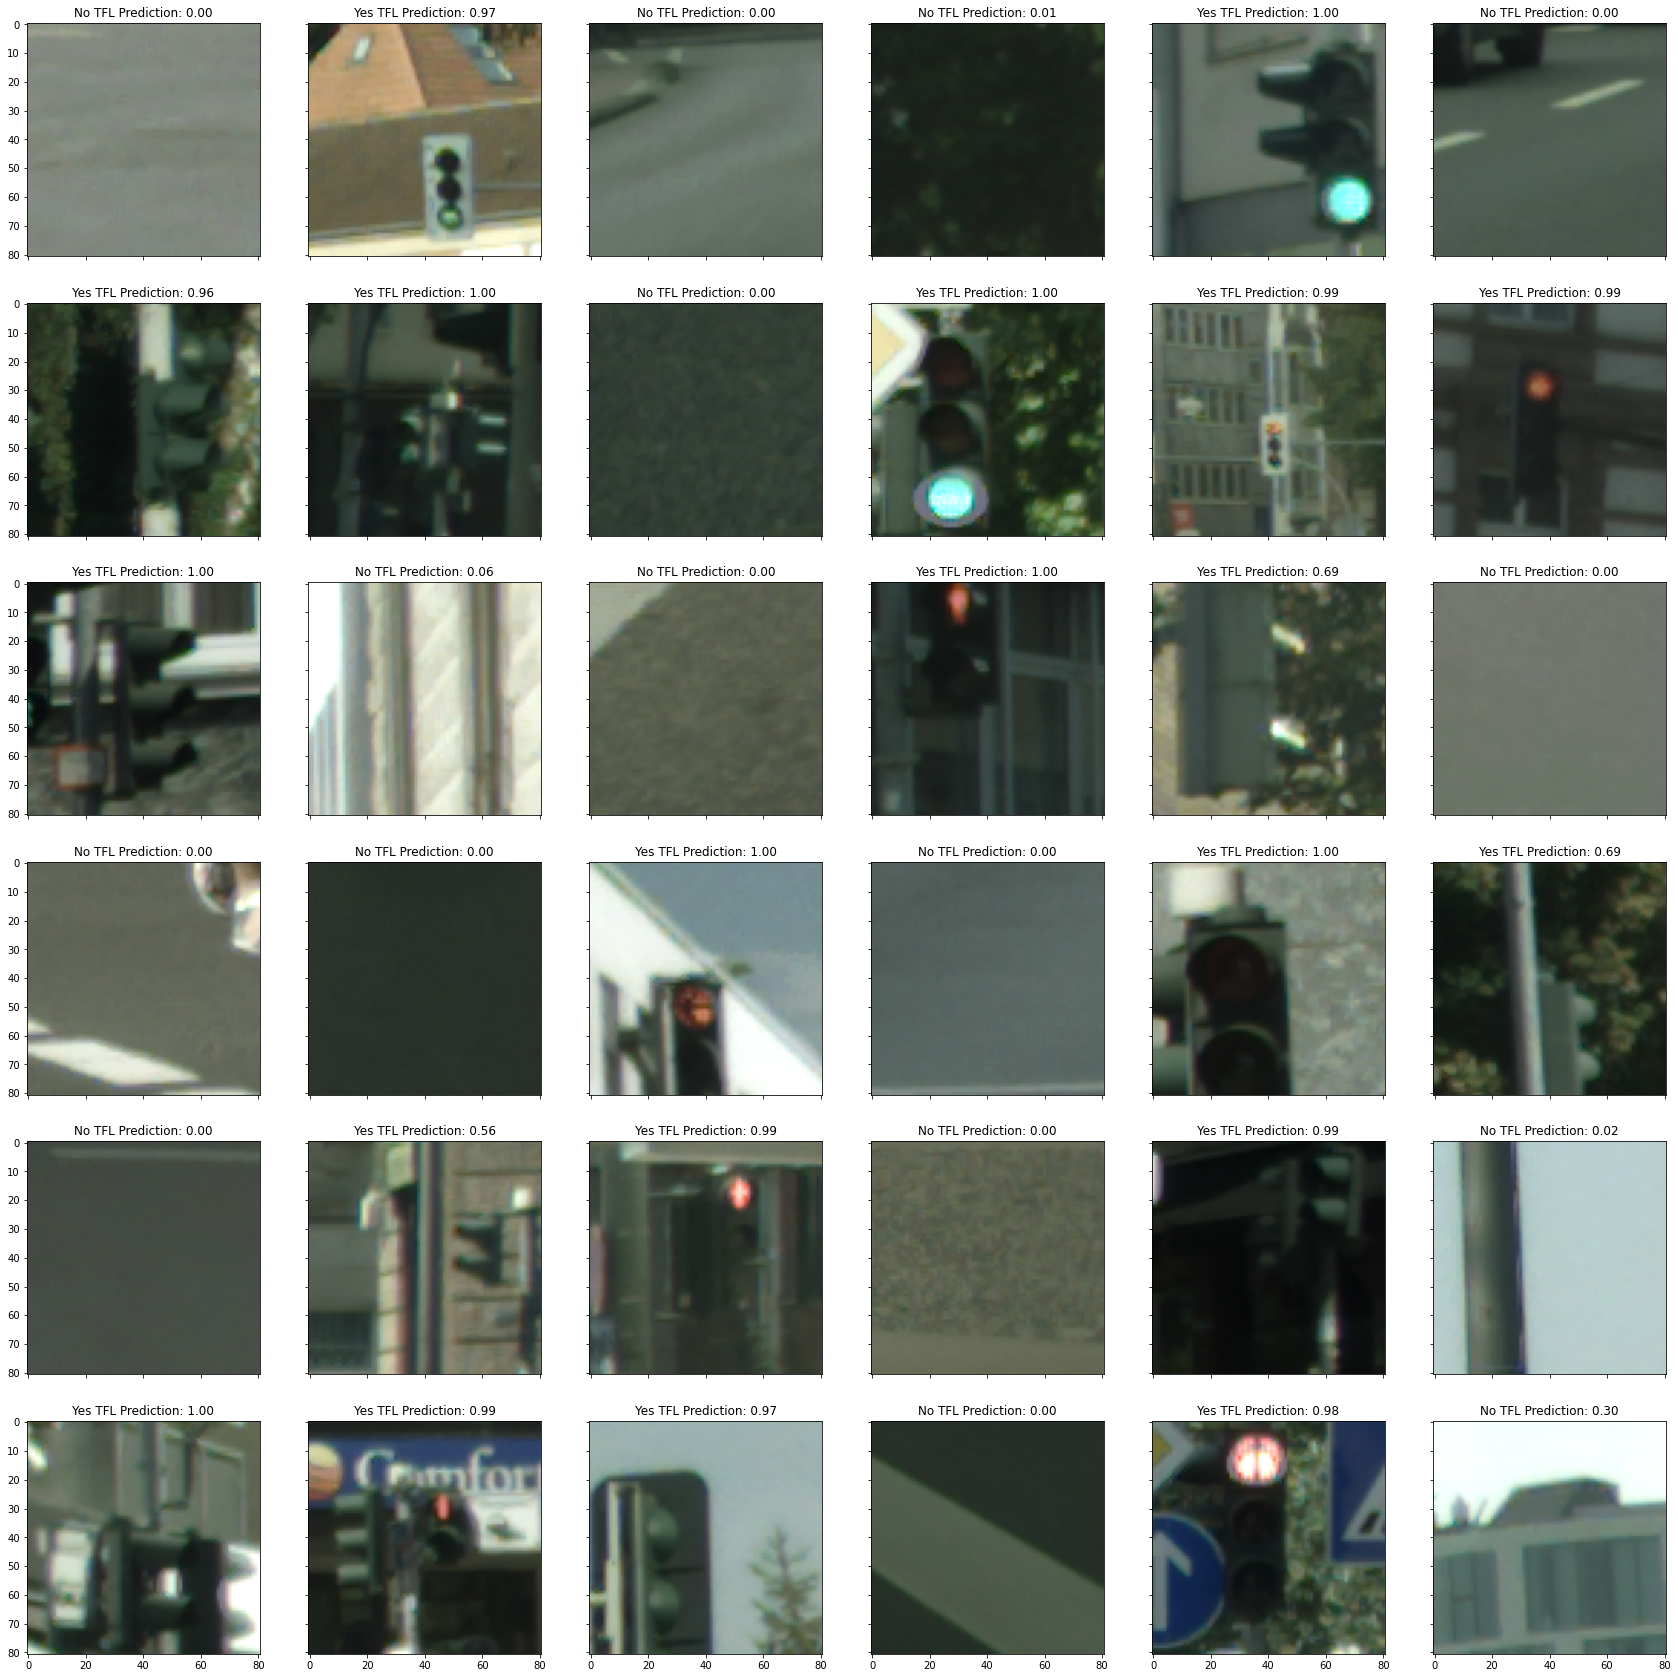

In [8]:
viz_my_data(num=(6,6),predictions=predictions[:,1],**val);

### Saving the model

In [9]:
m.save("model.h5")

### Loading the model

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("model.h5")
m = loaded_model